# Data Cleaning & Exploratory Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
#load in training data on each potential synapse
data = pd.read_csv("../Data/train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("../Data/feature_weights.csv")
morph_embeddings = pd.read_csv("../Data/morph_embeddings.csv")
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)


In [3]:
data.columns

Index(['ID', 'axonal_coor_x', 'axonal_coor_y', 'axonal_coor_z',
       'dendritic_coor_x', 'dendritic_coor_y', 'dendritic_coor_z', 'adp_dist',
       'post_skeletal_distance_to_soma', 'pre_skeletal_distance_to_soma',
       'pre_oracle', 'pre_test_score', 'pre_rf_x', 'pre_rf_y', 'post_oracle',
       'post_test_score', 'post_rf_x', 'post_rf_y', 'compartment',
       'pre_brain_area', 'post_brain_area', 'pre_nucleus_x', 'pre_nucleus_y',
       'pre_nucleus_z', 'post_nucleus_x', 'post_nucleus_y', 'post_nucleus_z',
       'pre_nucleus_id', 'post_nucleus_id', 'connected', 'pre_feature_weights',
       'post_feature_weights', 'pre_morph_embeddings',
       'post_morph_embeddings'],
      dtype='object')

In [4]:
# join all distance columns into a single np.array column
def dist_column(df, new_col, old_cols):
    df[new_col] = (
        df.filter(regex=old_cols)
        .sort_index(axis=1)
        .apply(lambda x: np.array(x), axis=1)
    )
    # delete the old columns
    df.drop(
        df.filter(regex=old_cols).columns, axis=1, inplace=True
    )
    return df

In [5]:
df = dist_column(data, "axonal_coords", "axonal_coor_")
df = dist_column(data, "dendritic_coords", "dendritic_coor_")
df = dist_column(data, "pre_rf_coords", "pre_rf_")
df = dist_column(data, "post_rf_coords", "post_rf_")
df = dist_column(data, "pre_nucleus_coords", "pre_nucleus_[xyz]")
df = dist_column(data, "post_nucleus_coords", "post_nucleus_[xyz]")

In [6]:
df.columns

Index(['ID', 'adp_dist', 'post_skeletal_distance_to_soma',
       'pre_skeletal_distance_to_soma', 'pre_oracle', 'pre_test_score',
       'post_oracle', 'post_test_score', 'compartment', 'pre_brain_area',
       'post_brain_area', 'pre_nucleus_id', 'post_nucleus_id', 'connected',
       'pre_feature_weights', 'post_feature_weights', 'pre_morph_embeddings',
       'post_morph_embeddings', 'axonal_coords', 'dendritic_coords',
       'pre_nucleus_coords', 'post_nucleus_coords'],
      dtype='object')

## Distance from Pre-Synaptic Nucleus to Axon
The presynaptic neuron is the one that transmits chemical information; perhaps if the distance between the nucleus of the presynaptic neuron and its axon is sufficiently large, the neuron's electrical charge will not be strong enough to form a connection.

In [7]:
# nuclei-adp euclidean distance
df["nuclei_adp_dist"] =  df[["pre_nucleus_coords", "axonal_coords"]].apply(lambda x: math.dist(x["pre_nucleus_coords"], x["axonal_coords"]), axis=1)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

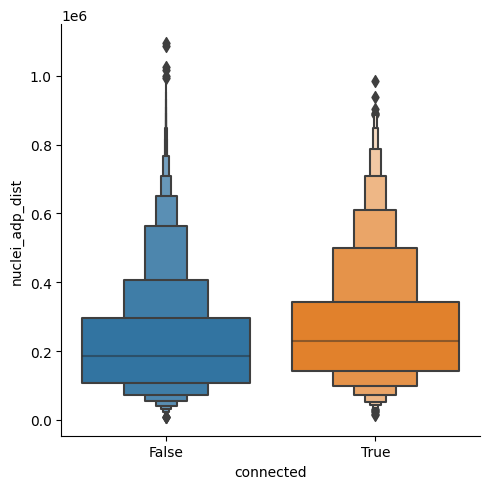

In [8]:
sns.catplot(data=df, x='connected', y='nuclei_adp_dist', kind='boxen')

## Pre-Synaptic Soma to ADP Distance
"Generally, axons form thousands of synapses that are often arranged like pearls on a string, with approximately one presynaptic specialization per 2-µm axon length" - The Cell Biology of Synapse Formation (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8186004/#:~:text=After%20neurons%20are%20born%2C%20migrate,under%20control%20of%20unknown%20signals.)
Perhaps the number of synapses formed is related to the length of the axon

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

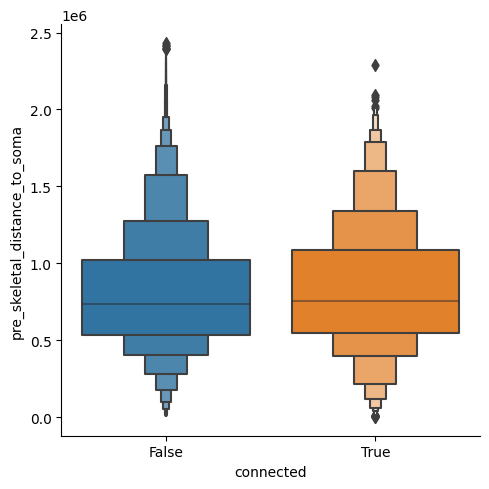

In [9]:
sns.catplot(data=df, x='connected', y='pre_skeletal_distance_to_soma', kind='boxen')

## Per-Neuron ADP Counts
How many ADPs are formed by each neuron? Maybe those with more ADPs will be more likely to have a connection.

In [10]:
counts = df.groupby('pre_nucleus_id').count() # count of each presynaptic neuron
counts = counts["ID"]
total_connections = df[["pre_nucleus_id", "connected"]].groupby('pre_nucleus_id').sum()
total_connections = total_connections["connected"]
adp_counts = pd.DataFrame([counts, total_connections]).transpose()
adp_counts = adp_counts.rename(columns={"ID":"count"})
adp_counts["connect_rate"] = adp_counts["connected"]/adp_counts["count"]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='count', ylabel='connected'>

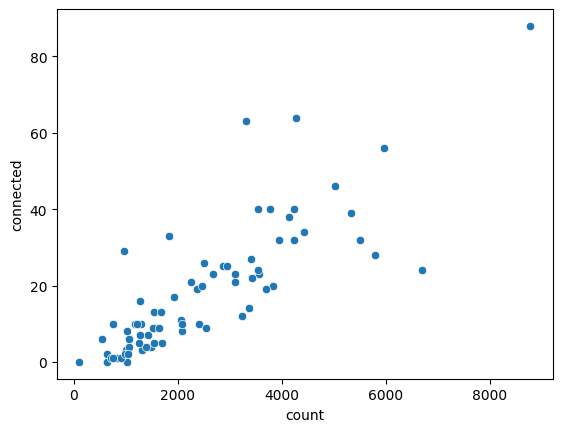

In [11]:
# scatter plot of adp count vs number connected
sns.scatterplot(data=adp_counts, x="count", y="connected")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='connect_rate', ylabel='Count'>

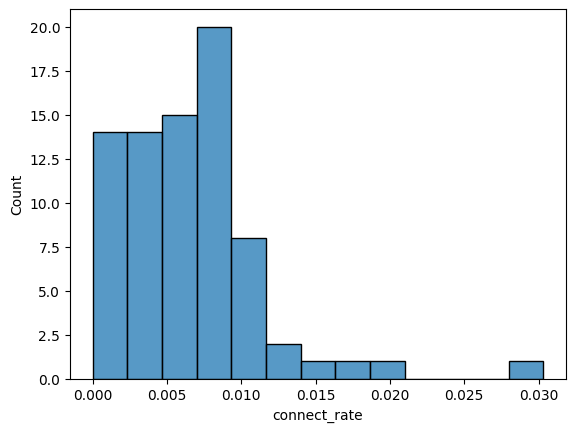

In [12]:
# bar graph of connection rate vs count
sns.histplot(data=adp_counts, x="connect_rate")

In [13]:
# which neurons have the highest connection rate? Let's look at the features of these neurons
adp_counts.sort_values(by="connect_rate", ascending=False)

,count,connected,connect_rate
pre_nucleus_id,,,
269247,956,29,0.030335
330079,3308,63,0.019045
330326,1834,33,0.017993
258307,4277,64,0.014964
612352,745,10,0.013423
...,...,...,...
583891,629,0,0.000000
256443,1019,0,0.000000
580826,635,0,0.000000


In [16]:
counts = df.groupby('pre_nucleus_id').count() # count of each presynaptic neuron
counts = counts["ID"]
total_connections = df[["pre_nucleus_id", "connected"]].groupby('pre_nucleus_id').sum()
total_connections = total_connections["connected"]
adp_counts = pd.DataFrame([counts, total_connections]).transpose()
adp_counts = adp_counts.rename(columns={"ID":"ADP_total", "connected":"connect_total"})
adp_counts["connect_rate"] = adp_counts["connect_total"]/adp_counts["ADP_total"]
print(adp_counts)
data = df.merge(adp_counts, left_on='pre_nucleus_id', right_on='pre_nucleus_id')
data.columns

                ADP_total  connect_total  connect_rate
pre_nucleus_id                                        
189149               4242             32      0.007544
222998               5512             32      0.005806
223037               3108             23      0.007400
224565               1534             13      0.008475
230236               2403             10      0.004161
...                   ...            ...           ...
610498               6706             24      0.003579
610535                719              1      0.001391
610615               1213             10      0.008244
612266                747              1      0.001339
612352                745             10      0.013423

[77 rows x 3 columns]


Index(['ID', 'adp_dist', 'post_skeletal_distance_to_soma',
       'pre_skeletal_distance_to_soma', 'pre_oracle', 'pre_test_score',
       'post_oracle', 'post_test_score', 'compartment', 'pre_brain_area',
       'post_brain_area', 'pre_nucleus_id', 'post_nucleus_id', 'connected',
       'pre_feature_weights', 'post_feature_weights', 'pre_morph_embeddings',
       'post_morph_embeddings', 'axonal_coords', 'dendritic_coords',
       'pre_nucleus_coords', 'post_nucleus_coords', 'nuclei_adp_dist',
       'ADP_total', 'connect_total', 'connect_rate'],
      dtype='object')